In [3]:
!pip install scipy
#Import the dct and idct functions from scipy.fftpack
from scipy.fftpack import dct, idct

import numpy as np
#Import the dct and idct functions from scipy.fftpack
from scipy.fftpack import dct, idct
# Import the fft and ifft functions from scipy.fftpack
from scipy.fftpack import fft, ifft

def fdm(X, fs, fc, data_type='columns', filter_type='dct', sort_fc='descend', remove_mean=False, plot_subbands=True):
# Take care of Vector inputs for einsum()
# ValueError: einstein sum subscripts string contains too many subscripts for operand 0
    if data_type == 'rows':
        # axis = 1
        X = np.transpose(X)
    else:
        axis = 0
    if remove_mean:
        X = X - np.mean(X, axis=0)
    N = X.shape[0]
    # print(N)
    # fc=np.asarray([0, fs/64, fs/32, fs/16, fs/8, fs/4, fs/2])
    fc = np.sort(fc)  # always sort fc in ascending order
    # print(fc)
    if fc[0] != 0:
        fc = np.hstack((0, fc))
    if fc[-1] != fs/2:
        fc = np.hstack((fc, fs/2))

    if sort_fc == 'descend':
        fc[::-1].sort()
    # print(fc)
    # Padding - Append data as symmetric rows (mirroring) at the beginning and end of the matrix
    # if filter_type != 'dct':
        # pad_rows = int(N * append_ratio);  # one-side length of appended rows
        # # X_padded = np.pad(X, pad_width=((pad_rows,pad_rows), (0,0)), mode="symmetric", reflect_type='even', )
        # X_padded = np.pad(X, pad_width=((pad_rows,pad_rows), (0,0)), mode="reflect", reflect_type='even')
        # appended_length = X_padded.shape[0]  # Increased number of rows before and after appending data, twice of 'pad_rows'

    # if filter_type == 'dct' or filter_type == 'dft':
    if filter_type == 'dct':
        dct_type = 2
        K = np.round(2 * N * fc/fs).astype(int) # Vector operation - convert fc to k (digital freq)
        no_of_subbands = K.shape[0] - 1         # For DCT implementation
        Hk = np.zeros((N, 1, no_of_subbands))   # Create 3-D Matrix with third dimension as Fc filters

    if filter_type == 'dft':
        append_ratio = 0.02  # 2 %
        pad_rows = int(N * append_ratio)  # one-side length of appended rows
        X_padded = np.pad(X, pad_width=((pad_rows,pad_rows), (0,0)), mode="symmetric", reflect_type='even')
        # X_padded = np.pad(X, pad_width=((pad_rows,pad_rows), (0,0)), mode="reflect", reflect_type='even')
        appended_length = X_padded.shape[0]  # Increased number of rows before and after appending data, twice of 'pad_rows'
        L = appended_length
        N_fft = 2 * np.ceil(L/2).astype(int)        # make it even
        K = np.round(N_fft * fc/fs).astype(int)     # Vector operation - convert fc to k (digital freq)
        # print(K)
        no_of_subbands = K.shape[0] - 1             # For FFT implementation
        Hk = np.zeros((N_fft, 1, no_of_subbands))   # Create 3-D Matrix with third dimension as Fc filters

    for i in range(no_of_subbands):
        if filter_type == 'dct':
            if sort_fc == 'ascend':
                Hk[K[i] : K[i+1], :, i] = 1  # 0:48 slice means 0 to 47 only
            if sort_fc == 'descend':
                Hk[K[i+1] : K[i], :, i] = 1
        if filter_type == 'dft':
            if sort_fc == 'ascend':
                Hk[K[i] : K[i+1], :, i] = 1
                Hk[N_fft-K[i+1] : N_fft-K[i], :, i] = 1
            if sort_fc == 'descend':
                Hk[K[i+1] : K[i], :, i] = 1
                Hk[N_fft-K[i] : N_fft-K[i+1], :, i] = 1

    if filter_type == 'dct':
        Xk = dct(X, type=dct_type, n=N, axis=axis, norm='ortho', overwrite_x=False)
        # if X.shape[1] == 1:
        #     Yk = Xk * Hk
        # else:
        #     Yk = np.einsum('ij,ijk->ijk', Xk, Hk)
        Yk = np.einsum('ij,ijk->ijk', Xk, Hk)  # Python Broadcasting, Order of Multiplication of dimensions
        Y = idct(Yk, type=dct_type, n=N, axis=axis, norm='ortho', overwrite_x=False)

    if filter_type == 'dft':
        Xk = 1/L * fft(X_padded, n=N_fft, axis=axis)  # Divide by L because of scaling in FFT & IFFT formulae
        # if X.shape[1] == 1:
        #     Yk = Xk * Hk
        # else:
        #     Yk = np.einsum('ij,ijk->ijk', Xk, Hk)  # Python Broadcasting
        Yk = np.einsum('ij,ijk->ijk', Xk, Hk)  # Python Broadcasting
        Y = L * ifft(Yk, n=N_fft, axis=axis, overwrite_x=False)
        Y = np.real(Y)  # Ignore the imaginary part
        Y = Y[pad_rows+1 : appended_length-pad_rows+1, :, :]  # Remove padded data i.e., revert back to orginal size of data

    if X.shape[1] == 1:  # Output is returned as a 2D matrix if input to the function is a column vector or a row vector
        FIBFs = np.squeeze(Y)
    else:
        FIBFs = Y  # Return output in 3D Matrix with the third dimension corresponding to different subbands

    if plot_subbands:
        # plt.show()
        t = np.arange(0, X.shape[0], 1) / fs
        fc = np.sort(fc)  # always sort fc in ascending order
        if fc[0] != 0:
            fc = [0, fc]
        if fc[-1] != fs/2:
            fc = [fc, fs/2]

        if sort_fc == 'descend':
            fc[::-1].sort()

        no_of_subbands = len(fc) - 1
        if no_of_subbands >= 6:
            m = np.floor(no_of_subbands/2) + 1
            n = 2  # Change to two-column tiled layout
        else:
            m = no_of_subbands + 1
            n = 1

        # First create a grid of plots
        # ax will be an array of two Axes objects
        # fig, ax = plt.subplots(m, n)
        # fig, ax = plt.subplots(m, n, figsize = (15, 10))
        # Call plot() method on the appropriate object
        # ax[0].plot(x, np.sin(x))
        # ax[1].plot(x, np.cos(x));
        if n == 2:
            plt.figure(figsize=(16, 16))
        else:
            plt.figure(figsize=(8, 16))
        # print(m)
        # print(n)

        for k in range(no_of_subbands+1):
            plt.subplot(m, n, k+1)
            if k == 0:
                plt.plot(t, X[:, 0])
                plt.title('Signal')
            else:
                if X.shape[1] == 1:  # Check if column vector or matrix
                    plt.plot(t, FIBFs[:, k-1])  # Plotting just one channel of the multi channel data
                else:
                    plt.plot(t, FIBFs[:, 0, k-1])  # Plotting just one channel of the multi channel data

                if sort_fc == 'ascend':
                    plt.title('FIBF {0}: Between {1} Hz to {2} Hz'.format(k, fc[k-1], fc[k]))
                elif sort_fc == 'descend':
                    plt.title('FIBF {0}: Between {1} Hz to {2} Hz'.format(k, fc[k], fc[k-1]))
        # plt.title('Fourier Decomposition Method')

    if data_type == 'rows':
        if X.shape[1] == 1:  # Output is returned as a 2D matrix if input to the function is a column vector or a row vector
            return FIBFs.T
        else:
            return FIBFs.transpose(1, 0, 2)  # The final 3D Matrix is a collection of multiple 2D matrices
    return FIBFs

In [5]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

def generate_complex_signals_from_wav(file_path, n_samples=6000, n_points=3000):
    fs, clean_signal = wav.read(file_path)  # Load the .wav file
    clean_signal = clean_signal.mean(axis=1) if len(clean_signal.shape) > 1 else clean_signal  # Convert to mono
    clean_signal = clean_signal / np.max(np.abs(clean_signal))  # Normalize

    # Trim or pad signal
    if len(clean_signal) > n_points:
        clean_signal = clean_signal[:n_points]
    elif len(clean_signal) < n_points:
        clean_signal = np.pad(clean_signal, (0, n_points - len(clean_signal)), 'constant')

    # Ensure n_samples is divisible by 3
    n_samples = n_samples - n_samples % 3  # Adjust if not divisible by 3

    # Create signals for all 3 classes (clean, noisy, phase-shifted)
    clean_signals = [clean_signal for _ in range(n_samples // 4)]
    noisy_signals = [signal + np.random.normal(0, 0.02, n_points) for signal in clean_signals]
    phase_shifted_signals = [np.roll(signal, np.random.randint(0, n_points)) + np.random.normal(0, 0.02, n_points) for signal in clean_signals]

    # Combine signals
    signals = np.vstack((clean_signals, noisy_signals, phase_shifted_signals))

    # Correct label distribution
    labels = np.array([0] * (n_samples // 3) + [1] * (n_samples // 3) + [2] * (n_samples // 3))

    # Debug: Check label distribution and signal shape
    print(f"Generated {signals.shape[0]} signals")
    print(f"Label distribution: {np.bincount(labels)}")

    return signals, labels, fs

# Generate signals and labels
signals, labels, fs = generate_complex_signals_from_wav(file_path='test1.wav', n_samples=5000, n_points=2500)

# Check labels
print(f"Label distribution in full dataset: {np.bincount(labels)}")


Generated 3747 signals
Label distribution: [1666 1666 1666]
Label distribution in full dataset: [1666 1666 1666]


In [6]:
fc = np.linspace(0, fs // 2, num=10)
fs = 5000  # Sampling frequency

# Initialize lists to store features and corresponding labels
features = []
corresponding_labels = []

# Iterate through each signal and its label
for signal, label in zip(signals, labels):
    # Apply Fourier Decomposition Method
    FIBFs = fdm(signal.reshape(-1, 1), fs, fc, data_type='columns', filter_type='dct', plot_subbands=False)
    epsilon = 1e-10
    normalized_FIBFs = (FIBFs - np.mean(FIBFs, axis=0)) / (np.std(FIBFs, axis=0) + epsilon)
    features.append(normalized_FIBFs.flatten())  # Flatten subbands into a single vector
    corresponding_labels.append(label)  # Store the corresponding label

# Convert lists to numpy arrays for consistency
features = np.array(features)
corresponding_labels = np.array(corresponding_labels)

# Sanity check: Ensure the features and labels have the same length
assert features.shape[0] == corresponding_labels.shape[0], "Mismatch between features and labels."

# Output shapes for confirmation
print(f"Features shape: {features.shape}")
print(f"Labels shape: {corresponding_labels.shape}")

Features shape: (3747, 25000)
Labels shape: (3747,)


Label distribution in full dataset: [1666 1666  415]
Label distribution in training set: [1316 1339  342]
Label distribution in test set: [350 327  73]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8760 - loss: 0.3288
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RNN (LSTM) Average Cross-Validation Accuracy: 0.7938
SVM Average Cross-Validation Accuracy: 0.7751
Random Forest Average Cross-Validation Accuracy: 0.7758
Decision Tree Average Cross-Validation Accuracy: 0.6613


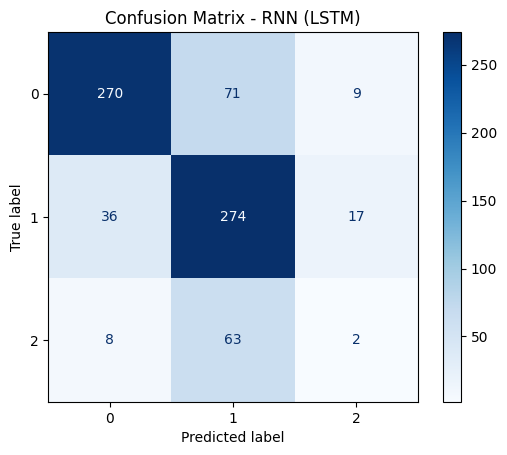

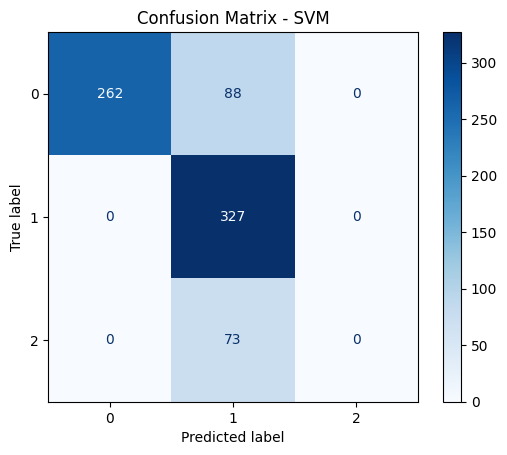

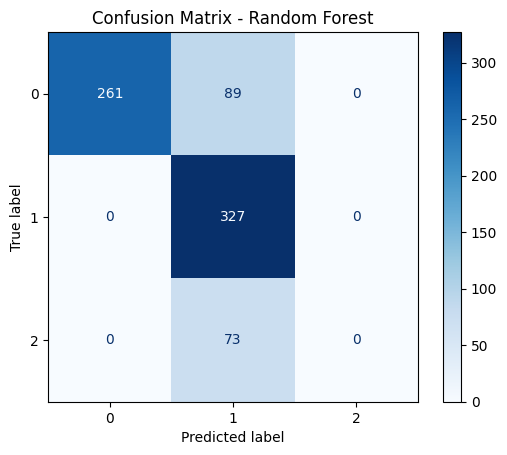

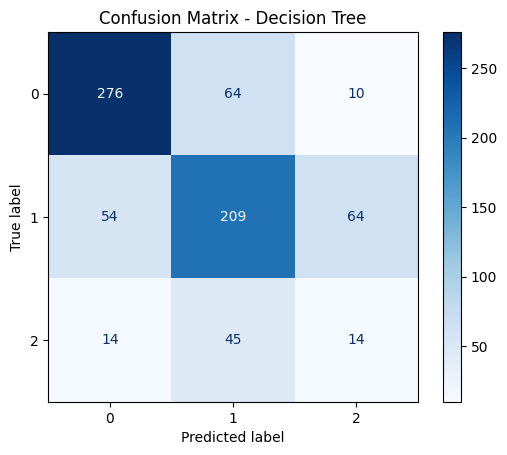

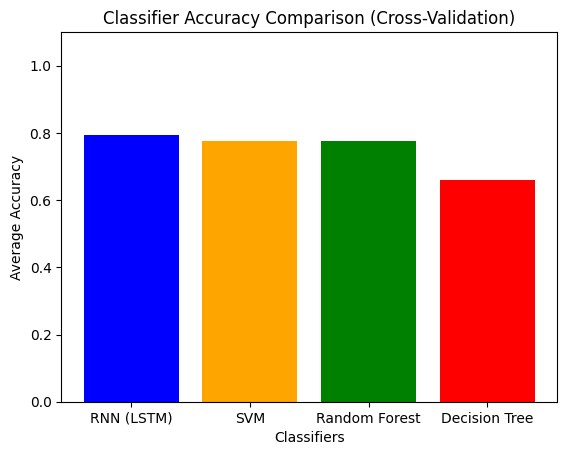

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from scipy.stats import randint
import matplotlib.pyplot as plt
import numpy as np

# Use extracted features and corresponding labels from FDM
X = features  # Replace signals with features from FDM
y = corresponding_labels  # Replace labels with corresponding labels

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Label distribution in full dataset:", np.bincount(corresponding_labels))
print("Label distribution in training set:", np.bincount(y_train))
print("Label distribution in test set:", np.bincount(y_test))

# Step 2: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Reduce to 10 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Reshape for RNN input (3D array: n_samples, timesteps, n_features)
X_train_rnn = X_train_pca.reshape(X_train_pca.shape[0], 1, X_train_pca.shape[1])  # (samples, timesteps, features)
X_test_rnn = X_test_pca.reshape(X_test_pca.shape[0], 1, X_test_pca.shape[1])  # (samples, timesteps, features)

# Step 4: Define classifiers
classifiers = {
    "RNN (LSTM)": Sequential([
        Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),  # Use Input layer for the shape
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(4, activation='softmax')  # 4 classes in the output layer
    ]),
    "SVM": SVC(kernel='rbf', C=1.0, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Step 5: Perform RandomizedSearchCV for Random Forest
param_distributions_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None],
}

random_search_rf = RandomizedSearchCV(
    classifiers["Random Forest"],
    param_distributions=param_distributions_rf,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Step 6: Perform cross-validation and evaluate accuracy
accuracies = {}
confusion_matrices = {}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    fold_accuracies = []

    # Cross-validation loop
    for train_idx, val_idx in cv.split(X_train_pca, y_train):
        X_train_cv, X_val_cv = X_train_pca[train_idx], X_train_pca[val_idx]
        y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]

        if name == "RNN (LSTM)":
            # Compile the RNN model
            clf.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            # Reshape for RNN input (3D array: n_samples, timesteps, n_features)
            X_train_cv_rnn = X_train_cv.reshape(X_train_cv.shape[0], 1, X_train_cv.shape[1])
            X_val_cv_rnn = X_val_cv.reshape(X_val_cv.shape[0], 1, X_val_cv.shape[1])

            # Train the RNN model
            clf.fit(X_train_cv_rnn, y_train_cv, epochs=10, batch_size=32, validation_data=(X_val_cv_rnn, y_val_cv), verbose=0)

            # Predict on validation set and convert probabilities to class labels
            y_pred = clf.predict(X_val_cv_rnn)
            y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
        elif name == "Random Forest":
            # Perform hyperparameter tuning
            random_search_rf.fit(X_train_cv, y_train_cv)
            clf = random_search_rf.best_estimator_  # Use the best model
            # Train the Random Forest model
            clf.fit(X_train_cv, y_train_cv)
            # Predict on validation set
            y_pred = clf.predict(X_val_cv)
        else:
            # Train the other classifiers
            clf.fit(X_train_cv, y_train_cv)
            # Predict on validation set
            y_pred = clf.predict(X_val_cv)

        # Calculate accuracy for this fold
        fold_accuracy = accuracy_score(y_val_cv, y_pred)
        fold_accuracies.append(fold_accuracy)

    # Calculate the average accuracy across all folds
    avg_accuracy = np.mean(fold_accuracies)
    accuracies[name] = avg_accuracy

    # Store the confusion matrix for the final model
    if name == "RNN (LSTM)":
        # Ensure reshaped input for the final model
        X_train_rnn_final = X_train_rnn.reshape(X_train_rnn.shape[0], 1, X_train_rnn.shape[2])
        X_test_rnn_final = X_test_rnn.reshape(X_test_rnn.shape[0], 1, X_test_rnn.shape[2])
        clf.fit(X_train_rnn_final, y_train)  # Fit on full training data after cross-validation
        y_pred = clf.predict(X_test_rnn_final)
    else:
        clf.fit(X_train_pca, y_train)  # Fit on full training data after cross-validation
        y_pred = clf.predict(X_test_pca)

    # Convert predictions to class labels (if necessary)
    if name == "RNN (LSTM)":
        y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels if output is not class label

    confusion_matrices[name] = (clf, y_test, y_pred)

    print(f"{name} Average Cross-Validation Accuracy: {avg_accuracy:.4f}")

# Step 7: Plot confusion matrices
for name, (clf, y_true, y_pred) in confusion_matrices.items():
    y_true = y_true.astype(int)  # Ensure integer labels
    y_pred = y_pred.astype(int)  # Ensure integer labels

    # Convert probabilities to class labels for RNN
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # For models like RNN

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Step 8: Compare results
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Classifiers")
plt.ylabel("Average Accuracy")
plt.title("Classifier Accuracy Comparison (Cross-Validation)")
plt.ylim(0, 1.1)
plt.show()
